# Exercise for PhD students and interested Master students


## Task (A): Detecting ARCH Effects in AR(1) Residuals

A.1 Load the data file "timeseries.csv" and assign the variable name $r_t$ to it 

A.2 Plot the time series of $r_t$

A.3 Use the Helper_TestingForARCHEffects file to evaluate whether there is evidence for heteroscedasticity in $r_t$. Use an AR(1) model and up to 10 lags of correlation in squared residuals. Do you reject the hypothesis of a constant vol in AR(1) residuals?



## Task (B): Fitting AR(1)-ARCH(1) using 2pass Regressions

B.1 Fit an AR(1)-ARCH(1) to $r_t$ by means of 2pass regression

B.2 Give out respective parameter estimates

B.3. Plot the resulting squared residuals.

B.4 Does the ARCH(1) capture all vs none vs a bit of the heteroscedasticity in $r_t$?



## Task (C): Fitting AR(1)-ARCH(1) using MLE

C.0 Write down the log likelihood function for $\{r_t\}_t$ assuming Gaussian errors.

C.1 Write a function Neg_loglikelihood_ar1_arch1() that takes as in put a list of model parameters. The function returns the negative log likelihood value of the observed time series $\{r_t\}_t$. Hint: You can treat $\{r_t\}_t$ as a global variable.

C.2 Find smart starting values for the unknown parameters. Hint: Rely on 2-pass regressions.

C.3 Rely on the scipy package and the Nelder-Mead optimization routine to conduct a MLE optimization of the negative log likelihood function.

C.4 Print out the MLE parameters 



## Task (D): Fitting AR(1)-GARCH(1,1) using MLE

D.0 Write down the log likelihood function for $\{r_t\}$ assuming Gaussian errors.

D.1 Write a function called garch11_variance(alpha_0, alpha_1, beta_1, sigma2_1, epsilon). The function returns a time series of GARCH(1,1) variance terms. Hint: sigma2_1 is a parameter and captures the first variance that starts the GARCH(1,1) recursion.

D.2 Write a function called Neg_loglikelihood_ar1_GARCH11(parameters). Parameters is a list of model parameters. The function returns the negative log likelihood of $\{r_t\}$.

D.3 Rely on 2pass regression to pin down smart starting values for "parameters". Use 0.1 and 1.0 for beta_1 and sigma2_1, respectively. 

D.4 Rely on the scipy package and the Nelder-Mead optimization routine to conduct a MLE optimization of the negative log likelihood function.

D.5 Print out the MLE parameters 

D.6 Refit the AR(1)-GARCH(1,1) model by using Python's arch_model. Do optimal parameters and log likelihood differ from D.5?

## A. Detecting ARCH Effects in Residuals of an AR(1) Process

See how to check for ARCH effects in error terms of an unknown DGP

In [1]:
#Necessary Python packages
import pandas as pd
import pylab as plt

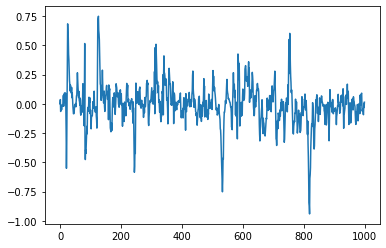

In [2]:
#Time-Series of interest
r_t = pd.read_csv("timeseries.csv", squeeze=True)
plt.plot(r_t);

In [3]:
#Run Portmanteau-Test on squared residuals of AR(1) process for an ARCH-lag of up to m
from ipynb.fs.defs.Helper_TestingForARCHEffects import Portmanteau_Test
#%run Helper_TestingForARCHEffects.ipynb

p = 1
m = 10
PT = Portmanteau_Test(r_t.values, p, m)

In [4]:
PT_pvl = PT[1]
print(PT_pvl)

5.823907401970265e-33


**Observation:**
    
We reject $H_0$ of a constant vol in AR(1) residuals and conclude that $r_t$ is heteroscedastic. Hence, we now have to think about how best to account for stochastic volatility in the return residuals.

## B. Fitting AR(p)-ARCH(m) using 2-Pass Regression

- **First, fit AR(p)** model of choice and get residuals

$$
\\
$$

- **Second, square residuals and fit an AR(m)** to it. The latter step does approximately identify the ARCH(m) dynamic  

In [5]:
#necessary packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
import scipy.optimize

**Application: AR(1)-ARCH(1)**

In [6]:
#First, get residuals from AR(1) fit
y = r_t.iloc[1:].values
X = np.ones((y.shape[0], 2))
X[:,1] = r_t.iloc[:-1].values

ar1 = sm.OLS(y,X).fit()
eps = ar1.resid

In [7]:
#summary stats of regression
print(ar1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2342.
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          5.99e-264
Time:                        15:23:03   Log-Likelihood:                 942.66
No. Observations:                 999   AIC:                            -1881.
Df Residuals:                     997   BIC:                            -1872.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.287      0.7

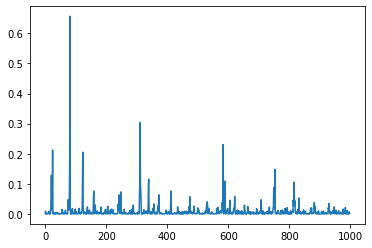

In [8]:
#plot of squared residuals
plt.plot(eps**2)

In [9]:
#Second, fit AR(1) to eps^2
y = eps[1:]**2
X = np.ones((y.shape[0], 2))
X[:,1] = eps[:-1]**2 

arch_1 = sm.OLS(y, X).fit()

In [10]:
#ARCH(1) parameters
arch_1.params

array([0.00562677, 0.3661949 ])

In [11]:
#summary stat of heteroscedasticity
print(arch_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     154.2
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           4.96e-33
Time:                        15:23:03   Log-Likelihood:                 2152.7
No. Observations:                 998   AIC:                            -4301.
Df Residuals:                     996   BIC:                            -4291.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.001      6.085      0.0

In [12]:
#Are ARCH(1) residuals homoscedastic? If not, m>1 necessary
print( Portmanteau_Test(arch_1.resid, 1, 10)[1]) #p-value of H_0 of homoscedastic innovations


1.2610961235632874e-05


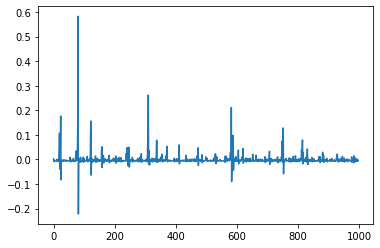

In [13]:
plt.plot(arch_1.resid)

**Observation:**

- (i): **ARCH(1) captures part, yet, not all of the heteroscedasticity in the time-series.**

$$
\\
$$

- (ii): **Either increase $m$ or, preferrably, move towards GARCH(1,1)**

## C. Fitting AR(1)-ARCH(1) using MLE

Remember: assuming Gaussian innovations one ends up with

$$
L_T(\phi_0, \phi_1, \alpha_0, \alpha_1) = \prod_{t=2}^T \frac{1}{\sqrt{ 2 \pi (\alpha_0 + \alpha_1 \epsilon^2_{t-1})}} \times \exp\left( -\frac{(r_t - [\phi_0 + \phi_1 r_{t-1}])^2}{2 (\alpha_0 + \alpha_1 \epsilon^2_{t-1})} \right)
$$

Remember:
$$
\ln (L_T(.)) = \sum_{t=2}^T -\frac{1}{2} \ln(2\pi [\alpha_0 + \alpha_1 \epsilon^2_{t-1}]) - \frac{1}{2}  \frac{(r_t - [\phi_0 + \phi_1 r_{t-1}])^2}{2 (\alpha_0 + \alpha_1 \epsilon^2_{t-1})} 
$$

In [14]:
# -ln( L_T(.) )

def Neg_loglikelihood_ar1_arch1(parameters):   # Parameters is a list of model parameters, here: [\phi_0, phi_1, alpha_0, alpha_1   ]  
    phi_0   = parameters[0]
    phi_1   = parameters[1]
    alpha_0 = parameters[2]
    alpha_1 = parameters[3]

    means = phi_0 + phi_1 * r_t.iloc[:-1].values
    eps   = r_t.iloc[1:].values - means
    vars_  = alpha_0 + alpha_1 * eps[:-1]**2
       
    loglikeli = np.sum(-0.5 * np.log(2 * math.pi * vars_) - (r_t.iloc[2:].values - means[1:])**2 / (2 * vars_))

    return -loglikeli

**Numerical Optimization of ln (L_T(.))**

In [15]:
#estimates of 2-pass estimation will be starting values  
ar1_arch1_params_start = [ar1.params[0], ar1.params[1], arch_1.params[0], arch_1.params[1]]
print(ar1_arch1_params_start)

[-0.0008576158677755598, 0.8375287214490452, 0.005626766756487489, 0.3661949018100925]


In [16]:
#Non-Constrained, non-linear optimization, i.e. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
ar1_arch1_params_optimal = scipy.optimize.minimize(Neg_loglikelihood_ar1_arch1, ar1_arch1_params_start, method = 'Nelder-Mead', options={'disp':True})

Optimization terminated successfully.
         Current function value: -1213.441158
         Iterations: 144
         Function evaluations: 247


In [17]:
#print optimal AR(1)-ARCH(1) parameters
print(ar1_arch1_params_optimal.x)

[-1.21494281e-04  8.12806208e-01  2.21445415e-03  8.26132317e-01]


## D. Fitting AR(1)-GARCH(1,1) using MLE

Note: assuming Gaussian innovations one ends up with

$$
L_T(\phi_0, \phi_1, \alpha_0, \alpha_1, \beta_1, \sigma_1) = \prod_{t=2}^T \frac{1}{\sqrt{ 2 \pi (\alpha_0 + \alpha_1 \epsilon^2_{t-1} + \beta_1 \sigma^2_{t-1})}} \times \exp\left( -\frac{(r_t - [\phi_0 + \phi_1 r_{t-1}])^2}{2 (\alpha_0 + \alpha_1 \epsilon^2_{t-1}+ \beta_1 \sigma^2_{t-1})} \right)
$$
with $\sigma^2_t = \alpha_0 + \alpha_1 \epsilon^2_{t-1} + \beta_1 \sigma^2_{t-1}, s.t. \sigma^2_1 = \text{known parameter}$

Note:
$$
\ln (L_T(.)) = \sum_{t=2}^T -\frac{1}{2} \ln(2\pi [\alpha_0 + \alpha_1 \epsilon^2_{t-1}+ \beta_1 \sigma^2_{t-1}]) - \frac{1}{2}  \frac{(r_t - [\phi_0 + \phi_1 r_{t-1}])^2}{2 (\alpha_0 + \alpha_1 \epsilon^2_{t-1}+ \beta_1 \sigma^2_{t-1})} 
$$

In [18]:
#calculate sigma^2_t parametrically using the GARCH(1,1) recursion

def garch11_variance(alpha_0, alpha_1, beta_1, sigma2_1, epsilon):
    sigma2 = np.zeros(epsilon.shape[0] - 1)
    sigma2[0] = alpha_0 + alpha_1 * epsilon[0]**2 + beta_1 * sigma2_1 
    for i in range(1, sigma2.shape[0]):
        sigma2[i] = alpha_0 + alpha_1 * epsilon[i]**2 + beta_1 * sigma2[i-1]
    
    return sigma2

In [19]:
# -ln( L_T(.) )

def Neg_loglikelihood_ar1_Garch11(parameters):   # Parameters is a list of model parameters, here: [\phi_0, phi_1, alpha_0, alpha_1, beta_1, sigma2_1]
    phi_0   = parameters[0]
    phi_1   = parameters[1]
    alpha_0 = parameters[2]
    alpha_1 = parameters[3]
    beta_1  = parameters[4]
    sigma2_1= parameters[5]
    
    means = phi_0 + phi_1 * r_t.iloc[:-1].values
    eps   = r_t.iloc[1:].values - means
    vars_  = garch11_variance(alpha_0, alpha_1, beta_1, sigma2_1, eps)
       
    loglikeli = np.sum(-0.5 * np.log(2 * math.pi * vars_) - (r_t.iloc[2:].values - means[1:])**2 / (2 * vars_))

    return -loglikeli

In [20]:
# AR(1)-ARCH(1,1) - 2pass estimates as start values
ar1_Garch11_params_start = [ar1.params[0], ar1.params[1], arch_1.params[0], arch_1.params[1], 0.01,1]
print(ar1_Garch11_params_start)

[-0.0008576158677755598, 0.8375287214490452, 0.005626766756487489, 0.3661949018100925, 0.01, 1]


In [21]:
#Non-Constrained, non-linear optimization, i.e. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
ar1_Garch11_params_optimal = scipy.optimize.minimize(Neg_loglikelihood_ar1_Garch11, ar1_Garch11_params_start, method = 'Nelder-Mead', options={'disp':True})

Optimization terminated successfully.
         Current function value: -1213.896831
         Iterations: 722
         Function evaluations: 1107


In [22]:
#print optimal AR(1)-GARCH(1,1) parameters
print(ar1_Garch11_params_optimal.x)

[-5.09644520e-05  8.12328802e-01  2.16728836e-03  8.22020385e-01
  7.66639221e-03  7.38296190e-01]


**solution from Python package ARCH_Model**

In [23]:
#get the ARCH-Model package
from arch import arch_model

$$r_t=const+ \phi r_{t-1}+\epsilon_t$$
$$\sigma^2_t = \omega + \alpha \epsilon_{t-1}^2 +\beta \sigma^2_{t−1}$$
$$\epsilon_t= \sigma_t e_t,\ e_t \sim \mathcal{N}(0,1)$$

In [24]:
#instantiate the AR(1)-GARCH(1,1) Model
am = arch_model(r_t, lags=1, mean="AR", vol="Garch", dist="Normal", rescale=False)

In [25]:
#fit the AR(1)-GARCH(1,1)
res = am.fit() #lowest NegL_opt(!!). Example of quality of pckge solutions

Iteration:      1,   Func. Count:      7,   Neg. LLF: -1115.9546193814917
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1115.9834004965962
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1116.494086938153
Iteration:      4,   Func. Count:     38,   Neg. LLF: -1123.2475148367796
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1196.61593284966
Iteration:      6,   Func. Count:     54,   Neg. LLF: -1203.6408305573457
Iteration:      7,   Func. Count:     62,   Neg. LLF: -1208.557615689951
Iteration:      8,   Func. Count:     70,   Neg. LLF: -1211.0772708615166
Iteration:      9,   Func. Count:     78,   Neg. LLF: -1214.3061335764758
Iteration:     10,   Func. Count:     86,   Neg. LLF: -1214.4994245591229
Iteration:     11,   Func. Count:     95,   Neg. LLF: -1214.5882974965944
Iteration:     12,   Func. Count:    103,   Neg. LLF: -1214.8087867339573
Iteration:     13,   Func. Count:    111,   Neg. LLF: -1214.8151334717788
Iteration:     14,   Func. Count:    120, 

In [26]:
res.loglikelihood

1214.8220109958463

**compare x_opt**

In [28]:
df_x = pd.DataFrame({
                   "arch_pckge()": res.params.values,
                  "local_no_bd ()": ar1_Garch11_params_optimal.x[:-1].round(5),
})
df_x

,arch_pckge(),local_no_bd ()
0,-0.000139,-0.00005
1,0.812189,0.81233
2,0.002170,0.00217
3,0.819816,0.82202
4,0.008585,0.00767


**compare L_opt**

In [29]:
df_Lopt = pd.DataFrame({
                   "arch_pckge(!,+)": res.loglikelihood,
                  "local_no_bd (-)": ar1_Garch11_params_optimal.fun ,
                    }, index=["Neg_L_opt"])
 
df_Lopt

,"arch_pckge(!,+)",local_no_bd (-)
Neg_L_opt,1214.822011,-1213.896831


**Observation:**

 